In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#import seaborn as sns
#import matplotlib as mlp
import matplotlib.pyplot as plt
#from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


# import dataset
dfPhiladelphia = pd.read_csv("data/tmp/dfPhiladelphia.csv.zip")
dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589215 entries, 0 to 589214
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   start_date                              589215 non-null  object 
 1   end_date                                589215 non-null  object 
 2   start_time_hourly                       589215 non-null  int64  
 3   end_time_hourly                         589215 non-null  int64  
 4   start_station_id                        589215 non-null  int64  
 5   end_station_id                          589215 non-null  int64  
 6   bike_id                                 589215 non-null  int64  
 7   start_latitude                          589215 non-null  float64
 8   start_longitude                         589215 non-null  float64
 9   end_latitude                            589215 non-null  float64
 10  end_longitude                           5892

# 4. Predictive Analytics

- Since the **total system-level demand in the next hour** is of our interest, the station-dependent demand is not needed in this task.
- Our target value is `y = numOfRentedBikes`

## 4.1 Feature Engineering

In this subtask, we will:
- Develop a rich set of features that we expect to be correlated with our target
- We will justify the selection of features

#### Creating the dataframe we need for our predicition.

In [2]:
# test for duplicates in start_date and start_time_hourly
len(dfPhiladelphia)-len(dfPhiladelphia.drop_duplicates(subset = ['start_date', 'start_time_hourly']))

580651

In [3]:
# drop the above checked duplicates, because we predict hourly
dfPhiladelphia.drop_duplicates(inplace=True, ignore_index = True,subset = ['start_date', 'start_time_hourly'])

In [4]:
# delete the last row of dfPhiladelphia, because its value is from 2020
dfPhiladelphia = dfPhiladelphia[:-1]

In [5]:
dfPhiladelphia['start_date'] = pd.to_datetime(dfPhiladelphia['start_date'])

In [6]:
dfPhiladelphia['start_day'] = dfPhiladelphia['start_date'].dt.day

In [7]:
dfPhiladelphia = dfPhiladelphia[['start_month', 'start_day', 'start_time_hourly', 'numOfRentedBikesHourly']]
dfPhiladelphia['year'] = 2019
dfPhiladelphia.rename(columns={"start_day": "day", "start_month": "month", "start_time_hourly": "hour"}, 
                      inplace = True)
dfPhiladelphia['date'] = pd.to_datetime(dfPhiladelphia[['year', 'month', 'day','hour']])
dfPhiladelphia

,month,day,hour,numOfRentedBikesHourly,year,date
0,1,1,0,2,2019,2019-01-01 00:00:00
1,1,1,1,8,2019,2019-01-01 01:00:00
2,1,1,2,10,2019,2019-01-01 02:00:00
3,1,1,3,7,2019,2019-01-01 03:00:00
4,1,1,4,3,2019,2019-01-01 04:00:00
...,...,...,...,...,...,...
8558,12,31,19,44,2019,2019-12-31 19:00:00
8559,12,31,20,33,2019,2019-12-31 20:00:00
8560,12,31,21,24,2019,2019-12-31 21:00:00
8561,12,31,22,26,2019,2019-12-31 22:00:00


In [8]:
# import dfWeather and edit it
dfWeather = pd.read_csv("data/tmp/dfWeather.csv")
dfWeather['date_time'] = pd.to_datetime(dfWeather['date_time'])
dfWeather = dfWeather[:-1]
dfWeather

,date_time,max_temp,min_temp,isPrecip
0,2019-01-01 00:00:00,6.950,6.4,True
1,2019-01-01 01:00:00,7.075,6.8,True
2,2019-01-01 02:00:00,7.200,7.2,True
3,2019-01-01 03:00:00,8.050,7.8,True
4,2019-01-01 04:00:00,9.400,8.3,True
...,...,...,...,...
8755,2019-12-31 19:00:00,7.375,7.1,False
8756,2019-12-31 20:00:00,7.800,7.8,False
8757,2019-12-31 21:00:00,8.300,8.3,False
8758,2019-12-31 22:00:00,8.300,8.3,False


In [9]:
# merge dfWeather and dfPhiladelphia
dfPhiladelphia = dfPhiladelphia[['date', 'numOfRentedBikesHourly']]
dfPhiladelphia = dfPhiladelphia.merge(dfWeather, left_on=["date"], 
                                      right_on=["date_time"], how="right")
dfPhiladelphia.drop(columns = ['date'], inplace = True)
dfPhiladelphia

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip
0,2.0,2019-01-01 00:00:00,6.950,6.4,True
1,8.0,2019-01-01 01:00:00,7.075,6.8,True
2,10.0,2019-01-01 02:00:00,7.200,7.2,True
3,7.0,2019-01-01 03:00:00,8.050,7.8,True
4,3.0,2019-01-01 04:00:00,9.400,8.3,True
...,...,...,...,...,...
8755,44.0,2019-12-31 19:00:00,7.375,7.1,False
8756,33.0,2019-12-31 20:00:00,7.800,7.8,False
8757,24.0,2019-12-31 21:00:00,8.300,8.3,False
8758,26.0,2019-12-31 22:00:00,8.300,8.3,False


**FEATURE: `daOfWeek`**

In [10]:
# creating dayOfWeek
dfPhiladelphia['dayOfWeek'] = pd.to_datetime(dfPhiladelphia["date_time"]).dt.day_name()
dfPhiladelphia.head()

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip,dayOfWeek
0,2.0,2019-01-01 00:00:00,6.950,6.4,True,Tuesday
1,8.0,2019-01-01 01:00:00,7.075,6.8,True,Tuesday
2,10.0,2019-01-01 02:00:00,7.200,7.2,True,Tuesday
3,7.0,2019-01-01 03:00:00,8.050,7.8,True,Tuesday
4,3.0,2019-01-01 04:00:00,9.400,8.3,True,Tuesday


**FEATURE: `isWeekend`**

In [11]:
def isWeekend(dayOfWeek):
    if(dayOfWeek in ["Saturday","Sunday"]):
        return True
    else:
        return False

In [12]:
dfPhiladelphia["isWeekend"] = dfPhiladelphia["dayOfWeek"].map(isWeekend)

**FEATURE: `isHoliday`**
- You need to install holidays

In [13]:
from datetime import date
import holidays

# Select country
us_holidays = holidays.US()
us_holidays

holidays.country_holidays('US')

In [14]:
dfPhiladelphia = dfPhiladelphia.assign(isHoliday=lambda x: x["date_time"].dt.date.apply(lambda h: h in us_holidays))

**FEATURE: `season`**

In [15]:
# Returns the day of the year
def day_match(ts):
    return pd.Period(ts, freq='D').day_of_year

#seasons = {'spring': (start='2019-03-20', end='2019-06-20'),
#           'summer': (start='2019/06/21', end='2019/09/22'),
#           'autumn': (start='2019/09/23', end='2019/12/21'),
#           'winter': rest}

# Create Array to map days to seasons (1 - 4)
seasons = ['winter' for i in range(0,78)]
seasons.extend('spring' for i in range(0,93))
seasons.extend('summer' for i in range(0,94))
seasons.extend('autumn' for i in range(0,90))
seasons.extend('winter' for i in range(0,10))

# Create dictionary for lambda expression
day_to_season = {}
for i in range(0,365):
    day_to_season[i+1] = seasons[i]
    
# Map start_date to day of the year (day_match) and afterwards map this to seasonnames (day_to_season)
dfPhiladelphia["season"] = dfPhiladelphia["date_time"].map(day_match).map(day_to_season)

In [16]:
print("In 2019 there were:\n", 
      "•", pd.Period("2019-03-19").day_of_year + (pd.Period("2019-12-31").day_of_year - pd.Period("2019/12/21").day_of_year), "winter days\n", 
      "•", pd.Period("2019/06/20").day_of_year - pd.Period("2019-03-19").day_of_year, "spring days\n",
      "•", pd.Period("2019/09/22").day_of_year - pd.Period("2019/06/20").day_of_year, "summer days\n",
      "•", pd.Period("2019/12/21").day_of_year - pd.Period("2019/09/22").day_of_year, "autumn days\n")

In 2019 there were:
 • 88 winter days
 • 93 spring days
 • 94 summer days
 • 90 autumn days



**FEATURE: `isRushhour`**
- Wikipedia: Rush hour may be 5–9 AM (5:00–9:00) and 4–8 PM (sometimes from 4-9 PM) (16:00–20:00 (sometimes from 16:00-21:00))
- TomTom: https://www.tomtom.com/traffic-index/philadelphia-traffic/#:~:text=2020-,2019,-Best%20time%20to
- We took the TomTom statistics for deciding, when rushhour is starting and ending, since it is tailored for Philadelphia 2019 traffic

In [17]:
# Create feature isRushour
def isRushhour(time):
    if (time in [7,8,9,16,17,18,19]):
        return True
    else: 
        return False

dfPhiladelphia['isRushhour'] = dfPhiladelphia['date_time'].dt.hour.apply(lambda x:isRushhour(x))
dfPhiladelphia.head()

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip,dayOfWeek,isWeekend,isHoliday,season,isRushhour
0,2.0,2019-01-01 00:00:00,6.950,6.4,True,Tuesday,False,True,winter,False
1,8.0,2019-01-01 01:00:00,7.075,6.8,True,Tuesday,False,True,winter,False
2,10.0,2019-01-01 02:00:00,7.200,7.2,True,Tuesday,False,True,winter,False
3,7.0,2019-01-01 03:00:00,8.050,7.8,True,Tuesday,False,True,winter,False
4,3.0,2019-01-01 04:00:00,9.400,8.3,True,Tuesday,False,True,winter,False


In [18]:
dfPhiladelphia

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip,dayOfWeek,isWeekend,isHoliday,season,isRushhour
0,2.0,2019-01-01 00:00:00,6.950,6.4,True,Tuesday,False,True,winter,False
1,8.0,2019-01-01 01:00:00,7.075,6.8,True,Tuesday,False,True,winter,False
2,10.0,2019-01-01 02:00:00,7.200,7.2,True,Tuesday,False,True,winter,False
3,7.0,2019-01-01 03:00:00,8.050,7.8,True,Tuesday,False,True,winter,False
4,3.0,2019-01-01 04:00:00,9.400,8.3,True,Tuesday,False,True,winter,False
...,...,...,...,...,...,...,...,...,...,...
8755,44.0,2019-12-31 19:00:00,7.375,7.1,False,Tuesday,False,False,winter,True
8756,33.0,2019-12-31 20:00:00,7.800,7.8,False,Tuesday,False,False,winter,False
8757,24.0,2019-12-31 21:00:00,8.300,8.3,False,Tuesday,False,False,winter,False
8758,26.0,2019-12-31 22:00:00,8.300,8.3,False,Tuesday,False,False,winter,False


**FEATURE: `start_month`, `start_day` and `start_time_hourly`**

In [19]:
#splitting date_time into month, day and hour
dfPhiladelphia['start_day'] = dfPhiladelphia['date_time'].dt.day
dfPhiladelphia['start_month'] = dfPhiladelphia['date_time'].dt.month
dfPhiladelphia['start_time_hourly'] = dfPhiladelphia['date_time'].dt.hour
dfPhiladelphia.drop(columns = ['date_time'], inplace = True)
dfPhiladelphia

,numOfRentedBikesHourly,max_temp,min_temp,isPrecip,dayOfWeek,isWeekend,isHoliday,season,isRushhour,start_day,start_month,start_time_hourly
0,2.0,6.950,6.4,True,Tuesday,False,True,winter,False,1,1,0
1,8.0,7.075,6.8,True,Tuesday,False,True,winter,False,1,1,1
2,10.0,7.200,7.2,True,Tuesday,False,True,winter,False,1,1,2
3,7.0,8.050,7.8,True,Tuesday,False,True,winter,False,1,1,3
4,3.0,9.400,8.3,True,Tuesday,False,True,winter,False,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,44.0,7.375,7.1,False,Tuesday,False,False,winter,True,31,12,19
8756,33.0,7.800,7.8,False,Tuesday,False,False,winter,False,31,12,20
8757,24.0,8.300,8.3,False,Tuesday,False,False,winter,False,31,12,21
8758,26.0,8.300,8.3,False,Tuesday,False,False,winter,False,31,12,22


#### Replace null values

In [20]:
# replace null values by zero (in numOfRentedBikesHourly)
dfPhiladelphia.fillna(0, inplace = True)

The feature creation process was already done in task 1: This are all features which we created in Task 1

**Remove unnecessary features**

We won't need:
- 'end_date', because
- 'end_time_hourly', because
- 'start_station_id', because we are interested in the **total system-level demand in the next hour**
- 'end_station_id', because
- 'start_latitude', because
- 'start_longitude', because
- 'end_latitude', because
- 'end_longitude', because
- 'start_station_name', because
- 'end_station_name', because
- 'tripduration_sec', because

We will need:
- 'start_date', because
- 'start_time_hourly', because
- 'numOfRentedBikes', because

We will test/evaluate if we need the following features, in a later step (x.x.x):
- 'min_temp', because
- 'max_temp', because
- 'precip', because
- 'user_type', because
- 'dayOfWeek', because
- 'isWeekend', because
- 'season', because
- 'isHoliday', because
- 'isRushhour', because
- #'tripLengthDistance', because

In [21]:
#Take only necessary columns (implicit drop of unselected columns)
dfPhiladelphia = dfPhiladelphia[['start_month', 'start_day', 'start_time_hourly', 'dayOfWeek',
                                'isWeekend', 'isHoliday', 'season', 'isRushhour','max_temp', 
                                 'min_temp', 'isPrecip','numOfRentedBikesHourly']]

### 4.1.1 Dummy Feature Creation (maybe after evaluation)
- We already created all features we need in Task 1, but we need to change some features into dummy variables to assure predictive performance

In [22]:
# here just 2 blocks of code

### 4.1.2 Justify the selection of features 

In [23]:
# Variance criteria or correlation criteria or filtering or embedded methods
# we will take variance & correlations

#### Variance:

In [24]:
#### take out features which will become dummys
#### season and so on missing, but we do know the variance because, we defined it
dfPhiladelphia[['start_time_hourly', 'min_temp', 'max_temp', 'isPrecip', 'dayOfWeek', 'isWeekend', 'isHoliday', 'isRushhour', 'numOfRentedBikesHourly']].var()

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_3850/1893051211.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfPhiladelphia[['start_time_hourly', 'min_temp', 'max_temp', 'isPrecip', 'dayOfWeek', 'isWeekend', 'isHoliday', 'isRushhour', 'numOfRentedBikesHourly']].var()


start_time_hourly           47.922137
min_temp                   103.864476
max_temp                   104.211228
isPrecip                     0.078957
isWeekend                    0.203769
isHoliday                    0.026650
isRushhour                   0.206621
numOfRentedBikesHourly    4310.690580
dtype: float64

In [25]:
# min_temp & max_temp same variance => validate if they have different values

#### Correlations

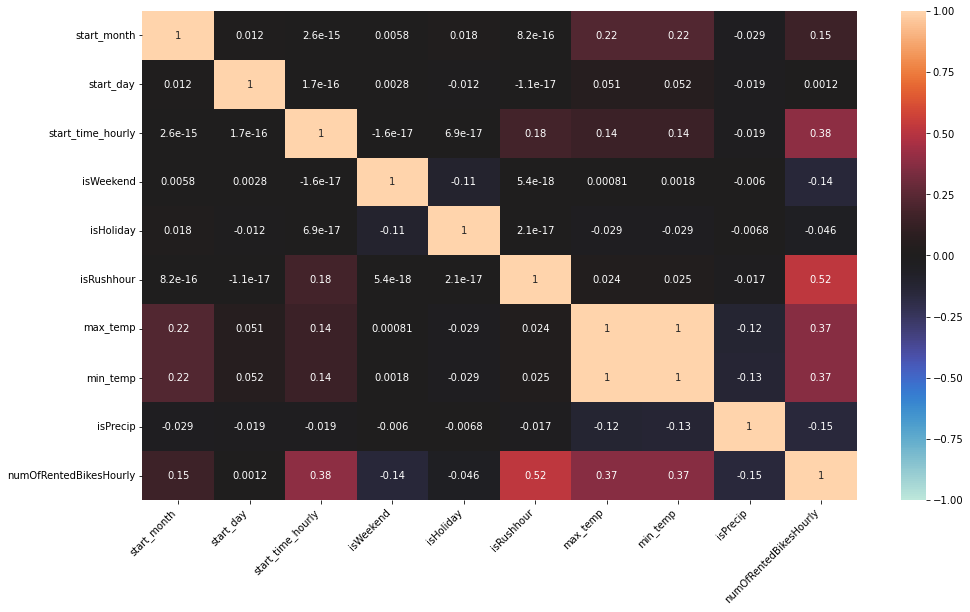

In [26]:
######## make named features like season to 0/1/2/3 so they show up here, before we make them a dummy variable like hours
import seaborn as sns
corr = dfPhiladelphia.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

#### ISSUMMER ETC ADDEN, user_type, (start_month)

#### Feature selection:
 
We will drop `max_temp` or `min_temp`, because they are perfectly correlated.

In [27]:
dfPhiladelphia.drop(columns = ['min_temp'], inplace = True)

### 4.1.3 (Visualisation of dependencies)

## 4.2 Model Building & Evaluation

In [28]:
# function for normalize numeric and encode categorical features and for create pipeline

def pipeline_for_prediction(categoric, numeric, model):
    
    numeric_transformer = Pipeline(steps=[("standard_scaler", StandardScaler())])
    categorical_transformer = Pipeline(
        steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical scaler", numeric_transformer, numeric),
            ("one hot encoder", categorical_transformer, categoric),
        ]
    )
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    return pipeline

In [29]:
# defining categorical and numeric features of dfPhiladelphia

categoric = ['isPrecip', 'start_time_hourly','dayOfWeek','isWeekend','start_month','start_day','season',
             'isHoliday','isRushhour']
numeric = ['max_temp']


In [30]:
# function for getting different scores for a model

def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [31]:
# function for creating pipeline and fitting model (created by the pipeline), predict and printing scores

def pipeline_fit_predict(reg, categoric, numeric, x_train, y_train, x_val, y_val):
    pipeline = pipeline_for_prediction(categoric, numeric, reg)
    pipeline.fit(x_train, y_train)
    y_predict = pipeline.predict(x_val)
    get_prediction_scores(y_val, y_predict)

**Split the dataset in trainset, validationset and testset (50-20-30)**

In [32]:
from sklearn.model_selection import train_test_split

#split the data set in 70% training set and 30% testing set
#x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(dfPhiladelphia.drop('numOfRentedBikesHourly', axis=1)
                                                    , dfPhiladelphia['numOfRentedBikesHourly'], 
                                                    test_size=0.3,random_state=42)

# save the combination of training and validation set in extra variables
x_train_val = x_train
y_train_val = y_train

#split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model

### 4.2.1 First Regression: Linear Regression (as Benchmark)

Using Linear Regression to predict the `numOfRentedBikesHourly`.

In [33]:
# creating the regression model

lin_reg = LinearRegression()

In [34]:
pipeline = pipeline_fit_predict(lin_reg, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  26.700
MSE:  1313.835
RMSE:  36.247
R2:  69.936 %
Max Residual Error:  163.838


### 4.2.2 Second Regression: Decision Tree

Using Decision Tree Regression to predict the `numOfRentedBikesHourly`.

In [35]:
# creating the regression model

tree_reg = DecisionTreeRegressor(criterion="friedman_mse", random_state=42) 

In [36]:
pipeline = pipeline_fit_predict(tree_reg, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  17.129
MSE:  818.330
RMSE:  28.606
R2:  81.274 %
Max Residual Error:  240.000


**Looking for the best Hyperparameters**

In [37]:
# function for finding the best hyperparameter by using RandomizedSearchCV and RepeatedStratifiedKFold
"""parameter:
   - pipeline: used pipeline for grid search (the pipeline contains the model)
   - x_val: data set (features) used for grid search
   - y_val: data set (target value) used for grid search
   - model_par: parameters for which the grid search is done
   - score: used score measure 
   - n_iter: how often grid search will be done
   - n_repeats: how often the data set is randomly splitted (by using the same random hyperparameter) in n_splits
   - n_splits: number of splits in RepeatedStratifiedKFold
   - verbose: getting information during the grid search
"""


from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

def find_best_hyperparameters(pipeline, x_val, y_val, model_par, score, n_iter = 50,  
                                   n_repeats=3, n_splits=5, n_jobs=1, verbose=True):
    
    print(f"Running grid search for the model based on {score}")
    grid_pipeline = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=model_par,
        n_jobs=n_jobs,
        n_iter=n_iter,
        cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42),
        scoring=score,
        random_state=42,
        verbose=verbose,
    )
    grid_pipeline.fit(x_val, y_val)
    print(f"Best {score} Score was: {grid_pipeline.best_score_}")
    print("The best hyper parameters for the model are:")
    print(grid_pipeline.best_params_)

In [38]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform

model_para = {'model__max_depth': range(1,51),
              'model__ccp_alpha': loguniform(1e-4, 40e-1)
             }

In [39]:
pipeline = pipeline_for_prediction(categoric, numeric, tree_reg)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['max_temp']),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['isPrecip',
                                                   'start_time_hourly',
                                                   'dayOfWeek', 'isWeekend',
                                                   'start_month', 'start_day',
                                                   'season', 'isHoliday',
                                                   'isRushhour'])])),
                ('model',
                 DecisionTreeRegressor(criterion='friedman_mse',
                                       random_state=42))])

In [40]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 1/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1020.943 total time=   0.0s
[CV 2/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 2/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1040.680 total time=   0.0s
[CV 3/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 3/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1129.662 total time=   0.0s
[CV 4/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 4/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1427.398 total time=   0.0s
[CV 5/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[C

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 7/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1231.258 total time=   0.0s
[CV 8/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 8/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1577.724 total time=   0.0s
[CV 9/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 9/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1117.554 total time=   0.0s
[CV 10/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 10/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1364.624 total time=   0.0s
[CV 11/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 11/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1164.914 total time=   0.0s
[CV 12/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 12/15;

[CV 7/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1106.304 total time=   0.0s
[CV 8/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 8/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1591.355 total time=   0.0s
[CV 9/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 9/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1171.558 total time=   0.0s
[CV 10/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 10/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1325.359 total time=   0.0s
[CV 11/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 11/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-1098.891 total time=   0.0s
[CV 12/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 12/15;

[CV 4/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-1443.718 total time=   0.0s
[CV 5/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 5/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-920.042 total time=   0.0s
[CV 6/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 6/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-1266.114 total time=   0.0s
[CV 7/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 7/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-1303.489 total time=   0.0s
[CV 8/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 8/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-1570.540 total time=   0.0s
[CV 9/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 9/15; 7/50] END m

[CV 3/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-1155.320 total time=   0.0s
[CV 4/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model__max_depth=21
[CV 4/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-1268.127 total time=   0.0s
[CV 5/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model__max_depth=21
[CV 5/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-907.924 total time=   0.0s
[CV 6/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model__max_depth=21
[CV 6/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-1390.025 total time=   0.0s
[CV 7/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model__max_depth=21
[CV 7/15; 10/50] END model__ccp_alpha=0.00010082864412217383, model__max_depth=21;, score=-1123.420 total time=   0.0s
[CV 8/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model_

[CV 1/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-1015.447 total time=   0.0s
[CV 2/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_depth=42
[CV 2/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-1031.881 total time=   0.0s
[CV 3/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_depth=42
[CV 3/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-1300.687 total time=   0.0s
[CV 4/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_depth=42
[CV 4/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-1399.802 total time=   0.0s
[CV 5/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_depth=42
[CV 5/15; 13/50] END model__ccp_alpha=0.0021890413960833736, model__max_depth=42;, score=-889.013 total time=   0.0s
[CV 6/15; 13/50] START model__ccp_alpha=0.0021890413960833736, model__max_depth

[CV 12/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-1215.297 total time=   0.0s
[CV 13/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 13/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-899.863 total time=   0.0s
[CV 14/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 14/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-1139.061 total time=   0.0s
[CV 15/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 15/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-1001.635 total time=   0.0s
[CV 1/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth=44
[CV 1/15; 16/50] END model__ccp_alpha=0.07012122794606233, model__max_depth=44;, score=-993.388 total time=   0.0s
[CV 2/15; 16/50] START model__ccp_alpha=0.07012122794606233, model__max_depth

[CV 15/15; 18/50] END model__ccp_alpha=0.906770412312764, model__max_depth=7;, score=-1561.555 total time=   0.0s
[CV 1/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_depth=39
[CV 1/15; 19/50] END model__ccp_alpha=0.0006092032999616391, model__max_depth=39;, score=-1013.748 total time=   0.0s
[CV 2/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_depth=39
[CV 2/15; 19/50] END model__ccp_alpha=0.0006092032999616391, model__max_depth=39;, score=-1031.061 total time=   0.0s
[CV 3/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_depth=39
[CV 3/15; 19/50] END model__ccp_alpha=0.0006092032999616391, model__max_depth=39;, score=-1299.449 total time=   0.0s
[CV 4/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_depth=39
[CV 4/15; 19/50] END model__ccp_alpha=0.0006092032999616391, model__max_depth=39;, score=-1398.540 total time=   0.0s
[CV 5/15; 19/50] START model__ccp_alpha=0.0006092032999616391, model__max_depth=39

[CV 13/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-759.410 total time=   0.0s
[CV 14/15; 21/50] START model__ccp_alpha=2.7790511850146156, model__max_depth=50
[CV 14/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-1065.226 total time=   0.0s
[CV 15/15; 21/50] START model__ccp_alpha=2.7790511850146156, model__max_depth=50
[CV 15/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-950.079 total time=   0.0s
[CV 1/15; 22/50] START model__ccp_alpha=0.005938952698993865, model__max_depth=26
[CV 1/15; 22/50] END model__ccp_alpha=0.005938952698993865, model__max_depth=26;, score=-1044.391 total time=   0.0s
[CV 2/15; 22/50] START model__ccp_alpha=0.005938952698993865, model__max_depth=26
[CV 2/15; 22/50] END model__ccp_alpha=0.005938952698993865, model__max_depth=26;, score=-1049.581 total time=   0.0s
[CV 3/15; 22/50] START model__ccp_alpha=0.005938952698993865, model__max_depth=26
[CV 3/15; 22

[CV 12/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1491.081 total time=   0.0s
[CV 13/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 13/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1241.628 total time=   0.0s
[CV 14/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 14/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1649.639 total time=   0.0s
[CV 15/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 15/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1544.372 total time=   0.0s
[CV 1/15; 25/50] START model__ccp_alpha=0.06415658128567595, model__max_depth=8.
[CV 1/15; 25/50] END model__ccp_alpha=0.06415658128567595, model__max_depth=8;, score=-1207.045 total time=   0.0s
[CV 2/15; 25/50] START model__ccp_alpha=0.06415658128567595, model__max_depth=8.
[C

[CV 9/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-1131.243 total time=   0.0s
[CV 10/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 10/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-1270.558 total time=   0.0s
[CV 11/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 11/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-1142.156 total time=   0.0s
[CV 12/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 12/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-1215.827 total time=   0.0s
[CV 13/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 13/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-898.921 total time=   0.0s
[CV 14/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 14/

[CV 7/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1225.464 total time=   0.0s
[CV 8/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 8/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1581.344 total time=   0.0s
[CV 9/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 9/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1120.390 total time=   0.0s
[CV 10/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 10/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1359.687 total time=   0.0s
[CV 11/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 11/15; 30/50] END model__ccp_alpha=0.04098179397821155, model__max_depth=29;, score=-1154.286 total time=   0.0s
[CV 12/15; 30/50] START model__ccp_alpha=0.04098179397821155, model__max_depth=29
[CV 12/15;

[CV 6/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-1181.670 total time=   0.0s
[CV 7/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14.
[CV 7/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-1090.896 total time=   0.0s
[CV 8/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14.
[CV 8/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-1445.309 total time=   0.0s
[CV 9/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14.
[CV 9/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-1046.231 total time=   0.0s
[CV 10/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14
[CV 10/15; 33/50] END model__ccp_alpha=1.3123484074006266, model__max_depth=14;, score=-1253.762 total time=   0.0s
[CV 11/15; 33/50] START model__ccp_alpha=1.3123484074006266, model__max_depth=14
[CV 11/15; 33/50] E

[CV 3/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-1300.116 total time=   0.0s
[CV 4/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 4/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-1405.235 total time=   0.0s
[CV 5/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 5/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-890.274 total time=   0.0s
[CV 6/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 6/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-1386.855 total time=   0.0s
[CV 7/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 7/15; 36/50] END model__ccp_alpha=0.024940807488720514, model__max_depth=40;, score=-1251.497 total time=   0.0s
[CV 8/15; 36/50] START model__ccp_alpha=0.024940807488720514, model__max_depth=40
[CV 8/

[CV 2/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-1031.079 total time=   0.0s
[CV 3/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 3/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-1300.705 total time=   0.0s
[CV 4/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 4/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-1399.105 total time=   0.0s
[CV 5/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 5/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-889.026 total time=   0.0s
[CV 6/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 6/15; 39/50] END model__ccp_alpha=0.004383290069341782, model__max_depth=45;, score=-1387.748 total time=   0.0s
[CV 7/15; 39/50] START model__ccp_alpha=0.004383290069341782, model__max_depth=45
[CV 7/

[CV 2/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-891.706 total time=   0.0s
[CV 3/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 3/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-1078.665 total time=   0.0s
[CV 4/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 4/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-1153.044 total time=   0.0s
[CV 5/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 5/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-865.316 total time=   0.0s
[CV 6/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 6/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-1064.806 total time=   0.0s
[CV 7/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24..
[CV 7/15; 42/50] END model_

[CV 2/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1309.065 total time=   0.0s
[CV 3/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 3/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1376.762 total time=   0.0s
[CV 4/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 4/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1416.453 total time=   0.0s
[CV 5/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 5/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1258.393 total time=   0.0s
[CV 6/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 6/15; 45/50] END model__ccp_alpha=0.0008224029745167574, model__max_depth=8;, score=-1410.155 total time=   0.0s
[CV 7/15; 45/50] START model__ccp_alpha=0.0008224029745167574, model__max_depth=8
[CV 7

[CV 2/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-1031.098 total time=   0.0s
[CV 3/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 3/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-1300.705 total time=   0.0s
[CV 4/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 4/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-1399.105 total time=   0.0s
[CV 5/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 5/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-889.018 total time=   0.0s
[CV 6/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 6/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-1387.750 total time=   0.0s
[CV 7/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 7/

Best neg_mean_squared_error Score was: -1027.0435724884328
The best hyper parameters for the model are:
{'model__ccp_alpha': 2.7790511850146156, 'model__max_depth': 50}


**Training the model with the best hyperparameters**

In [41]:
tree_reg_last = DecisionTreeRegressor(criterion="friedman_mse", ccp_alpha =  2.7790511850146156, max_depth = 50)

In [42]:
pipeline_last = pipeline_fit_predict(tree_reg_last, categoric, numeric, x_val, y_val, x_test, y_test)

MODEL SCORES:
MAE:  18.656
MSE:  891.003
RMSE:  29.850
R2:  80.023 %
Max Residual Error:  257.222


In [43]:
# plot decision tree

from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn import tree

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(dfPhiladelphia['max_temp'].values.reshape((-1,1)), dfPhiladelphia['numOfRentedBikesHourly'].values) 
    
    dot_data = export_graphviz(model,
                              feature_names=["max_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    
    return graph

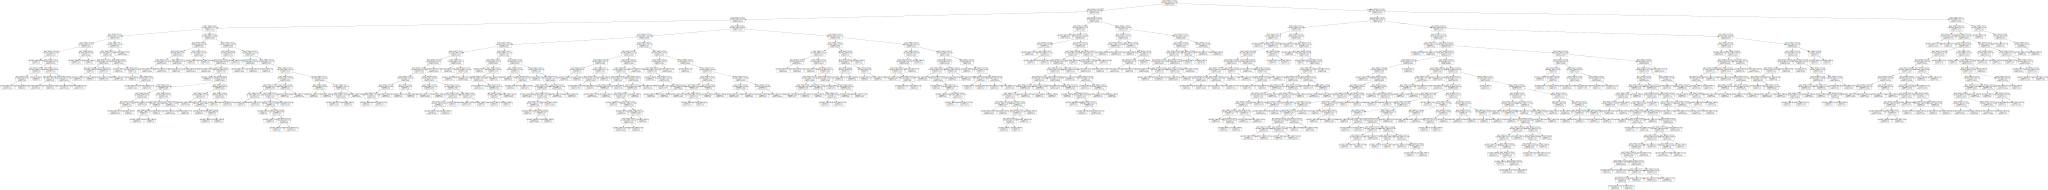

In [44]:
plot_regression_tree_sklearn(50)

### 4.2.2 Third Regression: Random Forest

Using Random Forest Regression to predict the `numOfRentedBikesHourly`.

In [45]:
# creating the regression model

forest_reg = RandomForestRegressor(n_estimators = 10,criterion="friedman_mse", random_state=42) 

In [46]:
pipeline = pipeline_fit_predict(forest_reg, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  14.675
MSE:  593.420
RMSE:  24.360
R2:  86.421 %
Max Residual Error:  220.000


**Looking for the best Hyperparameters**

In [47]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform
model_para = {'model__max_depth': range(1,51),
              'model__ccp_alpha': loguniform(1e-4, 40e-1)
             }

In [48]:
pipeline = pipeline_for_prediction(categoric, numeric, forest_reg)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['max_temp']),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['isPrecip',
                                                   'start_time_hourly',
                                                   'dayOfWeek', 'isWeekend',
                                                   'start_month', 'start_day',
                                                   'season', 'isHoliday',
                                                   'isRushhour'])])),
                ('model',
                 RandomForestRegressor(criterion='friedman_mse',
                                       n_estimators=10, random_state=42))])

In [49]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10, n_jobs=4)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 3/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 3/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-771.458 total time=   0.1s
[CV 7/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 7/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-682.221 total time=   0.1s
[CV 11/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 11/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-653.020 total time=   0.1s
[CV 15/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 15/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-777.813 total time=   0.1s
[CV 6/15; 2/50] START model__ccp_alpha=0.000698518491527025, model__max_depth=8.
[CV 6/15; 2/50] END model__ccp_alpha=0.000698518491527025, model__max_depth=8;, score=-887.344 total time=   0.1s
[CV 10/15; 2/50] 

[CV 2/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 2/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-709.671 total time=   0.1s
[CV 5/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 5/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-673.107 total time=   0.1s
[CV 10/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 10/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-781.918 total time=   0.1s
[CV 14/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 14/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-919.389 total time=   0.1s
[CV 5/15; 2/50] START model__ccp_alpha=0.000698518491527025, model__max_depth=8.
[CV 5/15; 2/50] END model__ccp_alpha=0.000698518491527025, model__max_depth=8;, score=-920.500 total time=   0.1s
[CV 7/15; 2/50] S

Best neg_mean_squared_error Score was: -750.3329964009224
The best hyper parameters for the model are:
{'model__ccp_alpha': 0.00010777537944204211, 'model__max_depth': 25}


**Training the model with the best hyperparameters**

In [50]:
forest_reg_end = RandomForestRegressor(n_estimators = 10,criterion="friedman_mse", ccp_alpha = 0.00010777537944204211,
                                       max_depth = 25)

In [51]:
pipeline_end = pipeline_fit_predict(forest_reg_end, categoric, numeric, x_val, y_val, x_test, y_test)

MODEL SCORES:
MAE:  15.378
MSE:  653.331
RMSE:  25.560
R2:  85.352 %
Max Residual Error:  235.700


### Fourth Regression: Lasso Regression

Using Lasso Regression to predict the `numOfRentedBikesHourly`.

In [52]:
# creating the regression model

lasso_reg = Lasso()

In [53]:
pipeline = pipeline_fit_predict(lasso_reg, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  32.508
MSE:  1862.131
RMSE:  43.152
R2:  57.389 %
Max Residual Error:  200.645


**Looking for the best Hyperparameters**

In [54]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform
model_para = {'model__alpha': loguniform(1e-2, 1e2),
              'model__tol' : loguniform(1e-5,1e0)
             }

In [55]:
pipeline = pipeline_for_prediction(categoric, numeric, lasso_reg)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['max_temp']),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['isPrecip',
                                                   'start_time_hourly',
                                                   'dayOfWeek', 'isWeekend',
                                                   'start_month', 'start_day',
                                                   'season', 'isHoliday',
                                                   'isRushhour'])])),
                ('model', Lasso())])

In [56]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 1/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1219.175 total time=   0.0s
[CV 2/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 2/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1487.647 total time=   0.0s
[CV 3/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 3/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1201.771 total time=   0.0s
[CV 4/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 4/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1608.695 total time=   0.0s
[CV 5/15; 1/50] START model__alpha=0.314891164795686, model

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 1/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-2800.690 total time=   0.0s
[CV 2/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 2/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-3061.228 total time=   0.0s
[CV 3/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 3/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-2896.223 total time=   0.0s
[CV 4/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 4/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-3368.280 total time=   0.0s
[CV 5/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 5/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-3118.510 total time=   0.0s
[CV 6/15; 2/50] START model__alpha=8.47180141881997

[CV 9/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2887.405 total time=   0.0s
[CV 10/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 10/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2742.781 total time=   0.0s
[CV 11/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 11/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2325.734 total time=   0.0s
[CV 12/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 12/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2481.109 total time=   0.0s
[CV 13/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 13/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2499.104 total time=   0.0s
[CV 14/15; 5/50] START model__alpha=2.53781

[CV 5/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1296.270 total time=   0.0s
[CV 6/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 6/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1290.533 total time=   0.0s
[CV 7/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 7/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1254.016 total time=   0.0s
[CV 8/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 8/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1368.483 total time=   0.0s
[CV 9/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 9/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1428.362 total time=   0.0s
[CV 10/15; 8/50] START m

[CV 6/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2468.567 total time=   0.0s
[CV 7/15; 11/50] START model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05
[CV 7/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2653.242 total time=   0.0s
[CV 8/15; 11/50] START model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05
[CV 8/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2358.850 total time=   0.0s
[CV 9/15; 11/50] START model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05
[CV 9/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2906.392 total time=   0.0s
[CV 10/15; 11/50] START model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05
[CV 10/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2762.053 total time=   0.0s
[CV 11/15; 11/50] STAR

[CV 6/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1288.334 total time=   0.0s
[CV 7/15; 14/50] START model__alpha=0.06290644294586147, model__tol=0.003725393839578885
[CV 7/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1252.401 total time=   0.0s
[CV 8/15; 14/50] START model__alpha=0.06290644294586147, model__tol=0.003725393839578885
[CV 8/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1367.506 total time=   0.0s
[CV 9/15; 14/50] START model__alpha=0.06290644294586147, model__tol=0.003725393839578885
[CV 9/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1428.163 total time=   0.0s
[CV 10/15; 14/50] START model__alpha=0.06290644294586147, model__tol=0.003725393839578885
[CV 10/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1381.848 total time=   0.0s
[CV 11/15; 14/50] STAR

[CV 1/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1229.257 total time=   0.0s
[CV 2/15; 17/50] START model__alpha=0.018205657658407256, model__tol=0.5551721685244724
[CV 2/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1465.374 total time=   0.0s
[CV 3/15; 17/50] START model__alpha=0.018205657658407256, model__tol=0.5551721685244724
[CV 3/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1164.316 total time=   0.0s
[CV 4/15; 17/50] START model__alpha=0.018205657658407256, model__tol=0.5551721685244724
[CV 4/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1602.681 total time=   0.0s
[CV 5/15; 17/50] START model__alpha=0.018205657658407256, model__tol=0.5551721685244724
[CV 5/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1319.364 total time=   0.0s
[CV 6/15; 17/50] START model__alp

[CV 10/15; 19/50] END model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05;, score=-1424.734 total time=   0.0s
[CV 11/15; 19/50] START model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05
[CV 11/15; 19/50] END model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05;, score=-1219.181 total time=   0.0s
[CV 12/15; 19/50] START model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05
[CV 12/15; 19/50] END model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05;, score=-1294.284 total time=   0.0s
[CV 13/15; 19/50] START model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05
[CV 13/15; 19/50] END model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05;, score=-1156.143 total time=   0.0s
[CV 14/15; 19/50] START model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05
[CV 14/15; 19/50] END model__alpha=0.16536937182824418, model__tol=3.0786517836196185e-05;, score=-1523.045 total time=   0.

[CV 10/15; 22/50] END model__alpha=0.013726318898045865, model__tol=0.3520481045526037;, score=-1369.480 total time=   0.0s
[CV 11/15; 22/50] START model__alpha=0.013726318898045865, model__tol=0.3520481045526037
[CV 11/15; 22/50] END model__alpha=0.013726318898045865, model__tol=0.3520481045526037;, score=-1260.996 total time=   0.0s
[CV 12/15; 22/50] START model__alpha=0.013726318898045865, model__tol=0.3520481045526037
[CV 12/15; 22/50] END model__alpha=0.013726318898045865, model__tol=0.3520481045526037;, score=-1300.515 total time=   0.0s
[CV 13/15; 22/50] START model__alpha=0.013726318898045865, model__tol=0.3520481045526037
[CV 13/15; 22/50] END model__alpha=0.013726318898045865, model__tol=0.3520481045526037;, score=-1154.432 total time=   0.0s
[CV 14/15; 22/50] START model__alpha=0.013726318898045865, model__tol=0.3520481045526037
[CV 14/15; 22/50] END model__alpha=0.013726318898045865, model__tol=0.3520481045526037;, score=-1532.643 total time=   0.0s
[CV 15/15; 22/50] START 

[CV 2/15; 26/50] END model__alpha=75.56810141274423, model__tol=0.07510418138777541;, score=-4397.374 total time=   0.0s
[CV 3/15; 26/50] START model__alpha=75.56810141274423, model__tol=0.07510418138777541
[CV 3/15; 26/50] END model__alpha=75.56810141274423, model__tol=0.07510418138777541;, score=-4279.768 total time=   0.0s
[CV 4/15; 26/50] START model__alpha=75.56810141274423, model__tol=0.07510418138777541
[CV 4/15; 26/50] END model__alpha=75.56810141274423, model__tol=0.07510418138777541;, score=-4736.894 total time=   0.0s
[CV 5/15; 26/50] START model__alpha=75.56810141274423, model__tol=0.07510418138777541
[CV 5/15; 26/50] END model__alpha=75.56810141274423, model__tol=0.07510418138777541;, score=-4448.105 total time=   0.0s
[CV 6/15; 26/50] START model__alpha=75.56810141274423, model__tol=0.07510418138777541
[CV 6/15; 26/50] END model__alpha=75.56810141274423, model__tol=0.07510418138777541;, score=-3992.944 total time=   0.0s
[CV 7/15; 26/50] START model__alpha=75.568101412744

[CV 1/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1231.544 total time=   0.1s
[CV 2/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 2/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1471.373 total time=   0.1s
[CV 3/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 3/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1149.433 total time=   0.1s
[CV 4/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 4/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1604.668 total time=   0.1s
[CV 5/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 5/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1294.060 total time=   0.1s
[CV 6/

[CV 10/15; 31/50] END model__alpha=0.35868164986275475, model__tol=0.0002273762810253685;, score=-1552.023 total time=   0.0s
[CV 11/15; 31/50] START model__alpha=0.35868164986275475, model__tol=0.0002273762810253685
[CV 11/15; 31/50] END model__alpha=0.35868164986275475, model__tol=0.0002273762810253685;, score=-1270.449 total time=   0.0s
[CV 12/15; 31/50] START model__alpha=0.35868164986275475, model__tol=0.0002273762810253685
[CV 12/15; 31/50] END model__alpha=0.35868164986275475, model__tol=0.0002273762810253685;, score=-1362.750 total time=   0.0s
[CV 13/15; 31/50] START model__alpha=0.35868164986275475, model__tol=0.0002273762810253685
[CV 13/15; 31/50] END model__alpha=0.35868164986275475, model__tol=0.0002273762810253685;, score=-1250.210 total time=   0.0s
[CV 14/15; 31/50] START model__alpha=0.35868164986275475, model__tol=0.0002273762810253685
[CV 14/15; 31/50] END model__alpha=0.35868164986275475, model__tol=0.0002273762810253685;, score=-1581.743 total time=   0.0s
[CV 15

[CV 4/15; 34/50] END model__alpha=0.03661819220392428, model__tol=0.10256162748473076;, score=-1596.504 total time=   0.0s
[CV 5/15; 34/50] START model__alpha=0.03661819220392428, model__tol=0.10256162748473076
[CV 5/15; 34/50] END model__alpha=0.03661819220392428, model__tol=0.10256162748473076;, score=-1298.526 total time=   0.0s
[CV 6/15; 34/50] START model__alpha=0.03661819220392428, model__tol=0.10256162748473076
[CV 6/15; 34/50] END model__alpha=0.03661819220392428, model__tol=0.10256162748473076;, score=-1297.249 total time=   0.0s
[CV 7/15; 34/50] START model__alpha=0.03661819220392428, model__tol=0.10256162748473076
[CV 7/15; 34/50] END model__alpha=0.03661819220392428, model__tol=0.10256162748473076;, score=-1261.185 total time=   0.0s
[CV 8/15; 34/50] START model__alpha=0.03661819220392428, model__tol=0.10256162748473076
[CV 8/15; 34/50] END model__alpha=0.03661819220392428, model__tol=0.10256162748473076;, score=-1375.373 total time=   0.0s
[CV 9/15; 34/50] START model__alp

[CV 11/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1233.524 total time=   0.0s
[CV 12/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 12/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1273.681 total time=   0.0s
[CV 13/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 13/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1150.411 total time=   0.0s
[CV 14/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 14/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1548.584 total time=   0.0s
[CV 15/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 15/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1496.885 total time=   0.0s
[CV 1/15; 38/50

[CV 10/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1489.823 total time=   0.0s
[CV 11/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 11/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1241.025 total time=   0.0s
[CV 12/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 12/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1328.255 total time=   0.0s
[CV 13/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 13/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1198.755 total time=   0.0s
[CV 14/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 14/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1546.403 total time=   0.0s
[CV 15

[CV 10/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1429.553 total time=   0.0s
[CV 11/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 11/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1220.345 total time=   0.0s
[CV 12/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 12/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1296.881 total time=   0.0s
[CV 13/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 13/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1159.007 total time=   0.0s
[CV 14/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 14/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1523.369 total time=   0.

[CV 7/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1260.893 total time=   0.0s
[CV 8/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 8/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1375.081 total time=   0.0s
[CV 9/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 9/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1428.774 total time=   0.0s
[CV 10/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 10/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1368.331 total time=   0.0s
[CV 11/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 11/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1227.829 total time=   0.0s
[CV 12/15; 46/50] ST

[CV 7/15; 49/50] END model__alpha=1.2329098365270508, model__tol=0.0013731092468240286;, score=-2151.602 total time=   0.0s
[CV 8/15; 49/50] START model__alpha=1.2329098365270508, model__tol=0.0013731092468240286
[CV 8/15; 49/50] END model__alpha=1.2329098365270508, model__tol=0.0013731092468240286;, score=-1926.874 total time=   0.0s
[CV 9/15; 49/50] START model__alpha=1.2329098365270508, model__tol=0.0013731092468240286
[CV 9/15; 49/50] END model__alpha=1.2329098365270508, model__tol=0.0013731092468240286;, score=-2305.273 total time=   0.0s
[CV 10/15; 49/50] START model__alpha=1.2329098365270508, model__tol=0.0013731092468240286
[CV 10/15; 49/50] END model__alpha=1.2329098365270508, model__tol=0.0013731092468240286;, score=-2293.944 total time=   0.0s
[CV 11/15; 49/50] START model__alpha=1.2329098365270508, model__tol=0.0013731092468240286
[CV 11/15; 49/50] END model__alpha=1.2329098365270508, model__tol=0.0013731092468240286;, score=-1869.492 total time=   0.0s
[CV 12/15; 49/50] ST

**Training the model with the best hyperparameters**

In [57]:
lasso_reg_end = Lasso(alpha=0.10842262717330158, tol = 0.020540519425388454)

In [58]:
pipeline_end = pipeline_fit_predict(lasso_reg_end, categoric, numeric, x_val, y_val, x_test, y_test)

MODEL SCORES:
MAE:  27.018
MSE:  1397.687
RMSE:  37.386
R2:  68.662 %
Max Residual Error:  167.368


### Fifth Regression: Support Vector Regression 

Using Support Vector Regression to predict the `numOfRentedBikesHourly`.

###### First we are testing the different kernels for taking it to look for the best hyperparameters.

#### Linear Kernel

In [59]:
from sklearn.svm import SVR

In [60]:
svr_linear = SVR(kernel = 'linear')

In [61]:
pipeline = pipeline_fit_predict(svr_linear, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  26.199
MSE:  1453.405
RMSE:  38.124
R2:  66.742 %
Max Residual Error:  200.313


#### Poly Kernel: degree 2

In [62]:
svr_poly2 = SVR(kernel = 'poly', degree=2)#cache_size=6000, max_iter=7500)

In [63]:
pipeline = pipeline_fit_predict(svr_poly2, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  28.679
MSE:  1764.094
RMSE:  42.001
R2:  59.632 %
Max Residual Error:  219.197


#### Poly Kernel: degree 3

In [64]:
svr_poly3 = SVR(kernel = 'poly',degree=3)#,cache_size=6000, max_iter=7500

In [65]:
pipeline = pipeline_fit_predict(svr_poly3, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  30.292
MSE:  1951.993
RMSE:  44.181
R2:  55.333 %
Max Residual Error:  229.028


#### RBF Kernel

In [66]:
svr_rbf = SVR(kernel = 'rbf')#,cache_size=6000, max_iter=7500)

In [67]:
pipeline = pipeline_fit_predict(svr_rbf, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  32.118
MSE:  2143.001
RMSE:  46.293
R2:  50.962 %
Max Residual Error:  240.788


###### The best kernel for support vector regression: Linear kernel

**Looking for the best Hyperparameters**

In [68]:
from scipy.stats import loguniform

model_para = {
                'model__C':loguniform(1e0, 1e3),
                'model__gamma':loguniform(1e-4, 1e1)
                }

In [69]:
pipeline = pipeline_for_prediction(categoric, numeric, svr_linear)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['max_temp']),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['isPrecip',
                                                   'start_time_hourly',
                                                   'dayOfWeek', 'isWeekend',
                                                   'start_month', 'start_day',
                                                   'season', 'isHoliday',
                                                   'isRushhour'])])),
                ('model', SVR(kernel='linear'))])

In [70]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 1/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1370.009 total time=   0.2s
[CV 2/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1570.613 total time=   0.2s
[CV 3/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 3/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1215.770 total time=   0.2s
[CV 4/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 4/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1615.135 total time=   0.1s
[CV 5/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 5/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1349.776 total time=   0.1s
[CV 6/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 6/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1326.525 total time=   0.1s
[CV 7/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 7

[CV 14/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1728.843 total time=   0.1s
[CV 15/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 15/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1704.252 total time=   0.1s
[CV 1/15; 4/50] START model__C=1.4936568554617629, model__gamma=2.142302175774106
[CV 1/15; 4/50] END model__C=1.4936568554617629, model__gamma=2.142302175774106;, score=-1471.742 total time=   0.1s
[CV 2/15; 4/50] START model__C=1.4936568554617629, model__gamma=2.142302175774106
[CV 2/15; 4/50] END model__C=1.4936568554617629, model__gamma=2.142302175774106;, score=-1686.040 total time=   0.1s
[CV 3/15; 4/50] START model__C=1.4936568554617629, model__gamma=2.142302175774106
[CV 3/15; 4/50] END model__C=1.4936568554617629, model__gamma=2.142302175774106;, score=-1398.052 total time=   0.1s
[CV 4/15; 4/50] START model__C=1.4936568554617629, model__gamma=2.142302175

[CV 12/15; 6/50] END model__C=1.1527987128232398, model__gamma=7.072114131472236;, score=-1536.272 total time=   0.1s
[CV 13/15; 6/50] START model__C=1.1527987128232398, model__gamma=7.072114131472236
[CV 13/15; 6/50] END model__C=1.1527987128232398, model__gamma=7.072114131472236;, score=-1467.746 total time=   0.1s
[CV 14/15; 6/50] START model__C=1.1527987128232398, model__gamma=7.072114131472236
[CV 14/15; 6/50] END model__C=1.1527987128232398, model__gamma=7.072114131472236;, score=-1849.945 total time=   0.1s
[CV 15/15; 6/50] START model__C=1.1527987128232398, model__gamma=7.072114131472236
[CV 15/15; 6/50] END model__C=1.1527987128232398, model__gamma=7.072114131472236;, score=-1860.565 total time=   0.1s
[CV 1/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612
[CV 1/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1360.422 total time=   1.7s
[CV 2/15; 7/50] START model__C=314.28808908401083, model__gamma=0.001152

[CV 7/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1363.741 total time=   0.1s
[CV 8/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 8/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1441.426 total time=   0.1s
[CV 9/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 9/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1551.328 total time=   0.1s
[CV 10/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 10/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1433.077 total time=   0.1s
[CV 11/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 11/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1244.636 total time=   0.1s
[CV 12/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869


[CV 2/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1570.776 total time=   0.1s
[CV 3/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 3/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1222.209 total time=   0.1s
[CV 4/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 4/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1620.841 total time=   0.1s
[CV 5/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 5/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1361.112 total time=   0.1s
[CV 6/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 6/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1314.133 total time=   0.1s
[CV 7/15; 12/50] START model__C=7.52374288

[CV 12/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1313.185 total time=   0.1s
[CV 13/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 13/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1261.243 total time=   0.1s
[CV 14/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 14/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1702.067 total time=   0.1s
[CV 15/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 15/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1672.294 total time=   0.1s
[CV 1/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643
[CV 1/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1369.714 total time=   0.3s
[CV 2/15; 15/50] START model__C=59.87474910461399

[CV 8/15; 17/50] END model__C=1.5673095467235412, model__gamma=5.551721685244724;, score=-1479.622 total time=   0.1s
[CV 9/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.551721685244724
[CV 9/15; 17/50] END model__C=1.5673095467235412, model__gamma=5.551721685244724;, score=-1789.936 total time=   0.1s
[CV 10/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.551721685244724
[CV 10/15; 17/50] END model__C=1.5673095467235412, model__gamma=5.551721685244724;, score=-1644.455 total time=   0.1s
[CV 11/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.551721685244724
[CV 11/15; 17/50] END model__C=1.5673095467235412, model__gamma=5.551721685244724;, score=-1350.429 total time=   0.1s
[CV 12/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.551721685244724
[CV 12/15; 17/50] END model__C=1.5673095467235412, model__gamma=5.551721685244724;, score=-1466.083 total time=   0.1s
[CV 13/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.5517

[CV 4/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1616.289 total time=   0.6s
[CV 5/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 5/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1338.788 total time=   0.4s
[CV 6/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 6/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1332.334 total time=   0.6s
[CV 7/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 7/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1349.640 total time=   0.4s
[CV 8/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 8/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1448.757 total time=   0.4s
[CV 9/15; 20/50] START model__C=112.90133559092668, model__g

[CV 15/15; 22/50] END model__C=1.2681352169084594, model__gamma=3.520481045526037;, score=-1837.011 total time=   0.1s
[CV 1/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 1/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1369.481 total time=   0.1s
[CV 2/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 2/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1567.646 total time=   0.1s
[CV 3/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 3/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1249.125 total time=   0.1s
[CV 4/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 4/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1627.504 total time=   0.1s
[CV 5/15; 23/50] START model__C=5.975027999960292, model__gamma=0.205

[CV 11/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1256.426 total time=   0.7s
[CV 12/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 12/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1273.653 total time=   0.2s
[CV 13/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 13/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1216.204 total time=   0.2s
[CV 14/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 14/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1635.525 total time=   0.4s
[CV 15/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 15/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1641.728 total time=   0.2s
[CV 1/15; 26/50] START model__C=810.501612

[CV 5/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-655.211 total time=   0.1s
[CV 6/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 6/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-735.904 total time=   0.1s
[CV 8/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 8/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1386.245 total time=   0.0s
[CV 9/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 9/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1129.002 total time=   0.0s
[CV 10/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 10/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1061.163 total time=   0.0s
[CV 11/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=

[CV 8/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1451.845 total time=   3.2s
[CV 9/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 9/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1517.424 total time=   3.7s
[CV 10/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 10/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1395.534 total time=   4.2s
[CV 11/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 11/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1257.204 total time=   3.3s
[CV 12/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 12/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1277.219 total time=   3.3s
[CV 13/15; 26/50] START model__C=810.5016126411582, model__gamma=0.75104

[CV 4/15; 29/50] END model__C=1.8427970406864536, model__gamma=0.0009548041810464162;, score=-1763.314 total time=   0.1s
[CV 5/15; 29/50] START model__C=1.8427970406864536, model__gamma=0.0009548041810464162
[CV 5/15; 29/50] END model__C=1.8427970406864536, model__gamma=0.0009548041810464162;, score=-1505.554 total time=   0.1s
[CV 6/15; 29/50] START model__C=1.8427970406864536, model__gamma=0.0009548041810464162
[CV 6/15; 29/50] END model__C=1.8427970406864536, model__gamma=0.0009548041810464162;, score=-1351.362 total time=   0.1s
[CV 7/15; 29/50] START model__C=1.8427970406864536, model__gamma=0.0009548041810464162
[CV 7/15; 29/50] END model__C=1.8427970406864536, model__gamma=0.0009548041810464162;, score=-1512.229 total time=   0.1s
[CV 8/15; 29/50] START model__C=1.8427970406864536, model__gamma=0.0009548041810464162
[CV 8/15; 29/50] END model__C=1.8427970406864536, model__gamma=0.0009548041810464162;, score=-1459.096 total time=   0.1s
[CV 9/15; 29/50] START model__C=1.84279704

[CV 14/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1647.114 total time=   0.2s
[CV 15/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685
[CV 15/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1623.306 total time=   0.1s
[CV 1/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 1/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1360.459 total time=   1.9s
[CV 2/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 2/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1571.163 total time=   2.2s
[CV 3/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 3/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1227.751 total time=   1.7s
[CV 4/15; 32/50] START model__C=306.3462210622081, model__ga

[CV 11/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1300.687 total time=   0.1s
[CV 12/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 12/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1369.810 total time=   0.1s
[CV 13/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 13/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1308.710 total time=   0.1s
[CV 14/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 14/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1733.641 total time=   0.1s
[CV 15/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 15/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1714.017 total time=   0.1s
[CV 1/15; 35/50] START model__C=1.6736010167825774, model__g

[CV 6/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1456.921 total time=   0.1s
[CV 7/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.1948328168545437
[CV 7/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1654.054 total time=   0.1s
[CV 8/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.1948328168545437
[CV 8/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1549.358 total time=   0.1s
[CV 9/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.1948328168545437
[CV 9/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1892.113 total time=   0.1s
[CV 10/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.1948328168545437
[CV 10/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1760.531 total time=   0.1s
[CV 11/15; 37/50] START model__C=1.0388823104027933, model__gamma=1

[CV 2/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1568.697 total time=   0.2s
[CV 3/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 3/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1216.604 total time=   0.1s
[CV 4/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 4/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1611.969 total time=   0.1s
[CV 5/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 5/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1351.139 total time=   0.1s
[CV 6/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 6/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1326.093 total time=   0.1s
[CV 7/15; 40/50] START model__C=1

[CV 12/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1279.793 total time=   0.1s
[CV 13/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 13/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1243.836 total time=   0.1s
[CV 14/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 14/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1675.587 total time=   0.1s
[CV 15/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 15/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1645.445 total time=   0.1s
[CV 1/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167
[CV 1/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1365.060 total time=   0.1s
[CV 2/15; 43/50] START model__C=8.5693319

[CV 7/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1351.994 total time=   2.0s
[CV 8/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 8/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1451.523 total time=   4.1s
[CV 9/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 9/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1516.288 total time=   2.1s
[CV 10/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 10/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1395.485 total time=   1.8s
[CV 11/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 11/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1257.044 total time=   3.2s
[CV 12/15; 45/50] START model__C=458.8156549160

[CV 2/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1571.255 total time=   0.9s
[CV 3/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 3/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1227.238 total time=   1.3s
[CV 4/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 4/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1616.121 total time=   1.6s
[CV 5/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 5/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1336.261 total time=   0.4s
[CV 6/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 6/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1330.667 total time=   1.1s
[CV 7/15; 48/50] START model__C=205.54245520150744, model__g

[CV 12/15; 50/50] END model__C=1.191948194791873, model__gamma=0.0003463037026119183;, score=-1530.932 total time=   0.1s
[CV 13/15; 50/50] START model__C=1.191948194791873, model__gamma=0.0003463037026119183
[CV 13/15; 50/50] END model__C=1.191948194791873, model__gamma=0.0003463037026119183;, score=-1463.338 total time=   0.1s
[CV 14/15; 50/50] START model__C=1.191948194791873, model__gamma=0.0003463037026119183
[CV 14/15; 50/50] END model__C=1.191948194791873, model__gamma=0.0003463037026119183;, score=-1839.351 total time=   0.1s
[CV 15/15; 50/50] START model__C=1.191948194791873, model__gamma=0.0003463037026119183
[CV 15/15; 50/50] END model__C=1.191948194791873, model__gamma=0.0003463037026119183;, score=-1849.880 total time=   0.1s
Best neg_mean_squared_error Score was: -1412.1529244123833
The best hyper parameters for the model are:
{'model__C': 191.58219548093157, 'model__gamma': 0.06403036652671171}


**Training the model with the best hyperparameters**

In [71]:
svr_linear_end = SVR(kernel = 'linear', gamma=0.06403036652671171, C= 191.58219548093157)

In [72]:
pipeline_end = pipeline_fit_predict(svr_linear_end, categoric, numeric, x_val, y_val, x_test, y_test)

MODEL SCORES:
MAE:  27.001
MSE:  1521.516
RMSE:  39.007
R2:  65.886 %
Max Residual Error:  168.229


### 4.2.3 Artificial Neural Network

- Before running you have to install tensorflow: `pip install tensorflow`

**Building the model with the functional API of Keras:**

In [ ]:
#pip install tensorflow

In [ ]:
# Import keras libraries
import tensorflow
from tensorflow inport keras
from keras import layers

In [ ]:
###### INTEGRATE HYPERPARAMTERTUNING TIPPS!
###### RELU IN EACH LAYER?

def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(8,)) # shapesize dependent of input features
    
    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)
    
    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)
    
    # Output Layer
    output = layers.Dense(1, activation='relu')(x)
    
    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='system_level_bike_rental_demand_philadelphia')
    
    # Compile the model
    model_ann.compile(optimizer='Adamax', loss='mean_squared_error') # MAYBE TRY DIFFERENT OPTIMIZER
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

You need to install keras_tuner first: You can use `pip install keras-tuner`

In [ ]:
#pip install keras-tuner

In [ ]:
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

Instantiate a tuner for hyperparametertuning:

- We choose the HyperBand Tuner from Keras

In [ ]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    #directory = os.path.normpath('C:/#######')
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Show a summary of the search space:

In [ ]:
tuner.search_space_summary()

To clear the training outputs after each training step define a callback:

In [ ]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Hyperparameter Search:

In [ ]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Show a summary of the results which presents the best model, the hyperparameters and the metrics:

In [ ]:
tuner.results_summary()

Get optimal hyperparameters:

In [ ]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps.get('total_added_hidden_layers')+1}.
""")

Get the best model:

In [ ]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show a summary of the model:

In [ ]:
model_ann.summary()

Plot the model as a graph:

You need to install pydot and graphivz. You can use: `conda install -c anaconda graphviz`and `conda install -c conda-forge python-graphviz` sequentially and `conda install -c conda-forge pydot`

In [ ]:
#pip install pydot

In [ ]:
keras.utils.plot_model(model_ann, 'model_ann_system_level_bike_rental_demand_philadelphia.png', show_shapes=True)

**Train the model:**

In hyperparameter tuning the model was only trained with 20 epochs because of the performance. So now we continue the training to get a optimal result.

Define a callback which stops earlier when their is no further improvement and which avoids overfitting:

In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50, 
    restore_best_weights=True 
    )

In [ ]:
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

**Evaluation of the performance of the model:**

In [ ]:
pred_ann = model_ann.predict(x_test)

# Calculate MAE and RMSE
mae_ann = mean_absolute_error(y_test,pred_ann)
rmse_ann = mean_squared_error(y_test,pred_ann)**0.5

print("MAE:", mae_ann)
print("RMSE:", rmse_ann)
print("Accuracy:", round((1-(mae_ann/dfPhiladelphia["numOfRentedBikes"].mean()))*100,2), "%")